## Particle tracking through a steady-state flow field on a structured grid

Application of a MODFLOW 6 particle-tracking (PRT) model to solve example 1 from the MODPATH 7 documentation.

This example problem involves a flow system consisting of two aquifers separated by a low conductivity confining layer, modeled on a nearly square structured grid with uniform square cells. There is a single well in the center of the grid, with a river running along the grid's right-hand boundary.

In part A, 21 particles are released at the water table in layer 1, all along the grid's third column, and tracked until discharge locations are reached. Some of the particles discharge to the well, while some discharge to the river.

In part B, 9 particles are released from points evenly distributed over the top faces of all cells in layer 1, then the capture zones of the river and the central well are computed.

### Problem setup

In [1]:
import os
import sys
from warnings import warn
import matplotlib as mpl
import matplotlib.pyplot as plt
import flopy
import numpy as np
import pandas as pd
from pathlib import Path

try:
    # append the common/ subdirectory to the system path
    # (assumes running one level down from project root)
    sys.path.append(os.path.join("..", "common"))
    import config

    buildModel = config.buildModel
    writeModel = config.writeModel
    runModel = config.runModel
    plotModel = config.plotModel
    plotSave = config.plotSave
    figure_ext = config.figure_ext
    base_ws = config.base_ws
    timeit = config.timeit
except:
    warn(f"Failed to import config")
    # default settings
    buildModel = True
    writeModel = True
    runModel = True
    plotModel = True
    plotSave = False
    figure_ext = ".png"
    base_ws = Path("../examples")

    def timeit(func):
        return func

Define figure properties.

In [2]:
# figure_size
figure_size = (12.5, 4.5)

# Pathline and starting point colors by capture destination
colordest = dict.fromkeys(["well", "river"], "blue")
colordest["well"] = "red"

Base simulation and model name and workspace

In [3]:
sim_name = "mp7-p01"
example_name = "ex-prt-" + sim_name
gwf_name = sim_name + "-gwf"
prt_name = sim_name + "-prt"
mp7_name = sim_name + "-mp7"

sim_ws = base_ws / example_name
mf6_ws = sim_ws / "mf6"
mp7_ws = sim_ws / "mp7"

mf6_ws.mkdir(exist_ok=True, parents=True)
mp7_ws.mkdir(exist_ok=True, parents=True)

headfile = f"{gwf_name}.hds"
budgetfile = f"{gwf_name}.cbb"
budgetfile_prt = f"{prt_name}.cbb"
trackfile_prt = f"{prt_name}.trk"
trackhdrfile_prt = f"{prt_name}.trk.hdr"
trackcsvfile_prt = f"{prt_name}.trk.csv"

Define model units.

In [4]:
length_units = "feet"
time_units = "days"

Define time discretization parameters.

In [5]:
nper, nstp, perlen, tsmult = 1, 1, 1.0, 1.0

Define MODFLOW 6 flow model parameters.

In [6]:
# Grid
nlay, nrow, ncol = 3, 21, 20
delr = delc = 500.0
top = 400.0
botm = [220.0, 200.0, 0.0]

# Layer types
laytyp = [1, 0, 0]

# Conductivities
kh = [50.0, 0.01, 200.0]
kv = [10.0, 0.01, 20.0]

# Well
wel_loc = (2, 10, 9)
wel_q = -150000.0

# Recharge
rch = 0.005
rch_iface = 6
rch_iflowface = -1

# River
riv_h = 320.0
riv_z = 317.0
riv_c = 1.0e5
riv_iface = 6
riv_iflowface = -1

Define data for the MODFLOW 6 well and river packages.

In [7]:
# Well package
wd = [(wel_loc, wel_q)]

# River package
rd = []
for i in range(nrow):
    rd.append([(0, i, ncol - 1), riv_h, riv_c, riv_z, riv_iface, riv_iflowface])

Define shared MODFLOW 6 PRT and MODPATH 7 particle-tracking model parameters.

In [8]:
# Porosity
porosity = 0.1

# Zones
def_zone = 1
wel_zone = 2
zones_lay1 = def_zone
zones_lay2 = def_zone
zones_lay3 = np.full((nrow, ncol), def_zone, dtype=np.int32)
zones_lay3[wel_loc[1:]] = wel_zone

# Starting location template size for example 1B;
# in the original example, there is initially a
# 3x3 array of particles in each cell in layer 1;
# in this example, there is initially one
# particle in each cell in layer 1; the original
# 3x3 particle arrays can be restored simply by
# setting sloc_tmpl_size below to 3 instead of 1.
sloc_tmpl_size = 1

Define MODPATH 7 model parameters.

In [9]:
# Zones
zones = [zones_lay1, zones_lay2, zones_lay3]

# Default iface
defaultiface = {"RCH": 6, "EVT": 6}

Define particle release point data for the MODFLOW 6 PRT particle-tracking model.

In [10]:
# Example 1A
releasepts = {}
releasepts["1A"] = []
zrpt = top
k = 0
j = 2
for i in range(nrow):
    nrpt = i
    xrpt = (j + 0.5) * delr
    yrpt = (nrow - i - 0.5) * delc
    rpt = [nrpt, k, i, j, xrpt, yrpt, zrpt]
    releasepts["1A"].append(rpt)

# Example 1B
releasepts["1B"] = []
ndivc = sloc_tmpl_size
ndivr = sloc_tmpl_size
deldivc = delc / ndivc
deldivr = delr / ndivr
k = 0
zrpt = top
nrpt = -1
for i in range(nrow):
    y0 = (nrow - i - 1) * delc
    for j in range(ncol):
        x0 = j * delr
        for idiv in range(ndivc):
            dy = (idiv + 0.5) * deldivc
            yrpt = y0 + dy
            for jdiv in range(ndivr):
                dx = (jdiv + 0.5) * deldivr
                xrpt = x0 + dx
                nrpt += 1
                rpt = [nrpt, k, i, j, xrpt, yrpt, zrpt]
                releasepts["1B"].append(rpt)

Define particle data for the MODPATH 7 model

In [11]:
# Example 1A
plocs = []
pids = []
for idx in range(nrow):
    plocs.append((0, idx, 2))
    pids.append(idx)
# issue(flopyex): in the flopy example this notebook is based on,
#  localz is not set to 1.0 like in the MODPATH examples doc,
#  so it defaults to 0.5, but it shouldn't really matter because
#  the particle gets placed at the water table anyway
part0 = flopy.modpath.ParticleData(
    plocs, drape=0, structured=True, particleids=pids, localz=1.0
)

# Example 1B
divs = sloc_tmpl_size
locs1b = [0, 0, 0, 0, nrow - 1, ncol - 1]
sd = flopy.modpath.CellDataType(
    drape=0, columncelldivisions=1, rowcelldivisions=1, layercelldivisions=1
)
sd = flopy.modpath.FaceDataType(
    drape=0,
    verticaldivisions1=0,
    horizontaldivisions1=0,
    verticaldivisions2=0,
    horizontaldivisions2=0,
    verticaldivisions3=0,
    horizontaldivisions3=0,
    verticaldivisions4=0,
    horizontaldivisions4=0,
    rowdivisions5=0,
    columndivisions5=0,
    rowdivisions6=divs,
    columndivisions6=divs,
)
p = flopy.modpath.LRCParticleData(subdivisiondata=[sd], lrcregions=[locs1b])

Define information used to extract and plot model results.

In [12]:
# Get well and river cell numbers
nodes = {}
k, i, j = wel_loc
nodes["well"] = ncol * (nrow * k + i) + j
nodes["river"] = []
for rivspec in rd:
    k, i, j = rivspec[0]
    node = ncol * (nrow * k + i) + j
    nodes["river"].append(node)

Define functions to build, write, run, and plot models. This example employs a shared MODFLOW 6 GWF + PRT simulation, and a separate MODPATH 7 simulation.

In [13]:
def build_model(example_name):
    print("Building models...{}".format(example_name))

    # ===============================
    # Create the MODFLOW 6 simulation
    # ===============================

    # Instantiate the MODFLOW 6 simulation object
    sim = flopy.mf6.MFSimulation(
        sim_name=gwf_name, exe_name="mf6", version="mf6", sim_ws=mf6_ws
    )

    # Instantiate the MODFLOW 6 temporal discretization package
    flopy.mf6.modflow.mftdis.ModflowTdis(
        sim,
        pname="tdis",
        time_units="DAYS",
        nper=nper,
        perioddata=[(perlen, nstp, tsmult)],
    )

    # -------------------
    # Build the GWF model
    # -------------------

    # Instantiate the MODFLOW 6 gwf (groundwater-flow) model
    model_nam_file = "{}.nam".format(gwf_name)
    gwf = flopy.mf6.ModflowGwf(
        sim, modelname=gwf_name, model_nam_file=model_nam_file, save_flows=True
    )

    # Instantiate the MODFLOW 6 gwf discretization package
    flopy.mf6.modflow.mfgwfdis.ModflowGwfdis(
        gwf,
        pname="dis",
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        length_units="FEET",
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
    )

    # Instantiate the MODFLOW 6 gwf initial conditions package
    flopy.mf6.modflow.mfgwfic.ModflowGwfic(gwf, pname="ic", strt=top)

    # Instantiate the MODFLOW 6 gwf node property flow package
    flopy.mf6.modflow.mfgwfnpf.ModflowGwfnpf(
        gwf,
        pname="npf",
        icelltype=laytyp,
        k=kh,
        k33=kv,
        save_saturation=True,
        save_specific_discharge=True,
    )

    # Instantiate the MODFLOW 6 gwf recharge package
    flopy.mf6.modflow.mfgwfrcha.ModflowGwfrcha(
        gwf,
        recharge=rch,
        auxiliary=["iface", "iflowface"],
        aux=[rch_iface, rch_iflowface],
    )

    # Instantiate the MODFLOW 6 gwf well package
    flopy.mf6.modflow.mfgwfwel.ModflowGwfwel(
        gwf, maxbound=1, stress_period_data={0: wd}
    )

    # Instantiate the MODFLOW 6 gwf river package
    flopy.mf6.modflow.mfgwfriv.ModflowGwfriv(
        gwf, auxiliary=["iface", "iflowface"], stress_period_data={0: rd}
    )

    # Instantiate the MODFLOW 6 gwf output control package
    head_record = [headfile]
    budget_record = [budgetfile]
    saverecord = [("HEAD", "ALL"), ("BUDGET", "ALL")]
    flopy.mf6.modflow.mfgwfoc.ModflowGwfoc(
        gwf,
        pname="oc",
        saverecord=saverecord,
        head_filerecord=head_record,
        budget_filerecord=budget_record,
    )

    # -------------------
    # Build the PRT model
    # -------------------

    # Instantiate the MODFLOW 6 prt model
    prt = flopy.mf6.ModflowPrt(
        sim, modelname=prt_name, model_nam_file="{}.nam".format(prt_name)
    )

    # Instantiate the MODFLOW 6 prt discretization package
    flopy.mf6.modflow.mfgwfdis.ModflowGwfdis(
        prt,
        pname="dis",
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        length_units="FEET",
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
    )

    # Instantiate the MODFLOW 6 prt model input package
    flopy.mf6.ModflowPrtmip(prt, pname="mip", porosity=porosity)

    # Instantiate the MODFLOW 6 prt particle release point (prp) package for example 1A
    flopy.mf6.ModflowPrtprp(
        prt,
        pname="prp1a",
        filename="{}_1a.prp".format(prt_name),
        nreleasepts=len(releasepts["1A"]),
        packagedata=releasepts["1A"],
        perioddata={
            0: ["FIRST"],
        },
    )

    # Instantiate the MODFLOW 6 prt particle release point (prp) package for example 1B
    flopy.mf6.ModflowPrtprp(
        prt,
        pname="prp1b",
        filename="{}_1b.prp".format(prt_name),
        nreleasepts=len(releasepts["1B"]),
        packagedata=releasepts["1B"],
        perioddata={
            0: ["FIRST"],
        },
    )

    # Instantiate the MODFLOW 6 prt output control package
    budget_record = [budgetfile_prt]
    track_record = [trackfile_prt]
    trackcsv_record = [trackcsvfile_prt]
    flopy.mf6.ModflowPrtoc(
        prt,
        pname="oc",
        budget_filerecord=budget_record,
        track_filerecord=track_record,
        trackcsv_filerecord=trackcsv_record,
        saverecord=[("BUDGET", "ALL")],
    )

    # Instantiate the MODFLOW 6 prt flow model interface
    flopy.mf6.ModflowPrtfmi(prt)

    # Create the MODFLOW 6 gwf-prt model exchange
    flopy.mf6.ModflowGwfprt(
        sim,
        exgtype="GWF6-PRT6",
        exgmnamea=gwf_name,
        exgmnameb=prt_name,
        filename="{}.gwfprt".format(gwf_name),
    )

    # --------------------------------------------------
    # Create solutions for the models in the simulation
    # --------------------------------------------------

    # Create an iterative model solution (IMS) for the MODFLOW 6 gwf model
    ims = flopy.mf6.ModflowIms(
        sim,
        pname="ims",
        complexity="SIMPLE",
        outer_dvclose=1e-6,
        inner_dvclose=1e-6,
        rcloserecord=1e-6,
    )

    # Create an explicit model solution (EMS) for the MODFLOW 6 prt model
    ems = flopy.mf6.ModflowEms(
        sim,
        pname="ems",
        filename="{}.ems".format(prt_name),
    )
    sim.register_solution_package(ems, [prt.name])

    # ===============================
    # Create the MODPATH 7 simulation
    # ===============================

    # Instantiate the MODPATH 7 simulation object
    mp7 = flopy.modpath.Modpath7(
        modelname=mp7_name,
        flowmodel=gwf,
        exe_name="mp7",
        model_ws=mp7_ws,
        budgetfilename=budgetfile,
        headfilename=headfile,
    )

    # Instantiate the MODPATH 7 basic data
    flopy.modpath.Modpath7Bas(mp7, porosity=porosity, defaultiface=defaultiface)

    # Instantiate the MODPATH 7 particle groups
    pg1a = flopy.modpath.ParticleGroup(
        particlegroupname="PG1A", particledata=part0, filename=sim_name + "a.sloc"
    )
    pg1b = flopy.modpath.ParticleGroupLRCTemplate(
        particlegroupname="PG1B", particledata=p, filename=sim_name + "b.sloc"
    )

    # Instantiate the MODPATH 7 simulation data
    mpsim = flopy.modpath.Modpath7Sim(
        mp7,
        simulationtype="combined",
        trackingdirection="forward",
        weaksinkoption="pass_through",
        weaksourceoption="pass_through",
        budgetoutputoption="summary",
        referencetime=[0, 0, 0.0],
        stoptimeoption="extend",
        timepointdata=[500, 1000.0],
        zonedataoption="on",
        zones=zones,
        particlegroups=[pg1a, pg1b],
    )

    # =======================
    # Return the simulations
    # =======================

    return sim, mp7

Define a function to write model files.

In [14]:
def write_model(sim, mp7, silent=True):
    sim.write_simulation(silent=silent)
    mp7.write_input()

Define a function to run the models.

In [15]:
@timeit
def run_model(sim, mp7, silent=True):
    # Run MODFLOW 6 simulation
    success, buff = sim.run_simulation(silent=silent, report=True)
    assert success
    for line in buff:
        print(line)

    # Run MODPATH 7 simulation
    success, buff = mp7.run_model(silent=silent, report=True)
    assert success
    for line in buff:
        print(line)

Define functions to load pathline and endpoint data from MODFLOW 6 PRT's particle track CSV files. Note that unlike MODPATH 7, MODFLOW 6 PRT does not make a distinction between pathline and endpoint output files &mdash; all pathline data is saved to track files, and endpoints are computed dynamically.

In [16]:
from flopy.plot.plotutil import to_mp7_pathlines, to_mp7_endpoints


def load_mf6pathlines(p):
    # read pathlines from CSV
    pls = pd.read_csv(p)

    # convert pathlines to mp7 format and split by particle group
    mp7_pls = to_mp7_pathlines(pls)
    mp7_pls_a = mp7_pls[mp7_pls["particlegroup"] == 1]
    mp7_pls_b = mp7_pls[mp7_pls["particlegroup"] == 2]

    # select endpoints, convert to mp7 format and split by particle group
    mp7_eps = to_mp7_endpoints(pls)
    mp7_eps_a = mp7_eps[mp7_eps["particlegroup"] == 1]
    mp7_eps_b = mp7_eps[mp7_eps["particlegroup"] == 2]

    # determine which particles ended up in which capture area
    # (for now, use x coordinate of endpoint, todo: use izone)
    wel_pids_a = mp7_eps_a[mp7_eps_a["x"] <= 9000]["particleid"].unique()
    riv_pids_a = mp7_eps_a[mp7_eps_a["x"] > 9000]["particleid"].unique()
    wel_pids_b = mp7_eps_b[mp7_eps_b["x"] <= 9000]["particleid"].unique()
    riv_pids_b = mp7_eps_b[mp7_eps_b["x"] > 9000]["particleid"].unique()

    # return a dict keyed by subproblem (particle group) and capture area
    return {
        ("1A", "well"): mp7_pls_a[mp7_pls_a["particleid"].isin(wel_pids_a)],
        ("1A", "river"): mp7_pls_a[mp7_pls_a["particleid"].isin(riv_pids_a)],
        ("1A", "all"): mp7_pls_a,
        ("1B", "well"): mp7_pls_b[(mp7_pls_b["particleid"].isin(wel_pids_b))],
        ("1B", "river"): mp7_pls_b[(mp7_pls_b["particleid"].isin(riv_pids_b))],
        ("1B", "all"): mp7_pls_b,
    }


def load_mf6endpoints(p):
    # read pathlines from CSV
    pls = pd.read_csv(p)

    # select endpoints, convert to mp7 format and split by particle group
    mp7_eps = to_mp7_endpoints(pls)
    mp7_eps_a = mp7_eps[mp7_eps["particlegroup"] == 1]
    mp7_eps_b = mp7_eps[mp7_eps["particlegroup"] == 2]

    # determine which particles ended up in which capture area
    # (for now, use x coordinate of endpoint, todo: use izone)
    wel_pids_a = mp7_eps_a[mp7_eps_a["x"] <= 9000]["particleid"].unique()
    riv_pids_a = mp7_eps_a[mp7_eps_a["x"] > 9000]["particleid"].unique()
    wel_pids_b = mp7_eps_b[mp7_eps_b["x"] <= 9000]["particleid"].unique()
    riv_pids_b = mp7_eps_b[mp7_eps_b["x"] > 9000]["particleid"].unique()

    # return a dict keyed by subproblem (particle group) and capture area
    return {
        ("1A", "well"): mp7_eps_a[mp7_eps_a["particleid"].isin(wel_pids_a)],
        ("1A", "river"): mp7_eps_a[mp7_eps_a["particleid"].isin(riv_pids_a)],
        ("1A", "all"): mp7_eps_a,
        ("1B", "well"): mp7_eps_b[mp7_eps_b["particleid"].isin(wel_pids_b)],
        ("1B", "river"): mp7_eps_b[mp7_eps_b["particleid"].isin(riv_pids_b)],
        ("1B", "all"): mp7_eps_b,
    }

Define a utility function for reading MODPATH 7 pathlines from output files.

In [17]:
def load_mp7pathlines(plf):
    # Extract pathline data to a dictionary keyed on subproblem (1A or 1B)
    # and capture destination (well or river)
    mp7pathlines = {}
    for dest in ["well", "river"]:
        pdata = plf.get_destination_pathline_data(nodes[dest], to_recarray=True)
        for pgidx, subprob in enumerate(["1A", "1B"]):
            mp7pathlines[(subprob, dest)] = np.array(
                [point for point in pdata if point["particlegroup"] == pgidx],
                dtype=pdata.dtype,
            )

    return mp7pathlines

Define a utility function for reading MODPATH 7 endpoint data from output files.

In [18]:
def load_mp7endpointdata(epf):
    # Extract endpoint data to a dictionary keyed on subproblem (1A or 1B)
    # and capture destination (well or river)
    mp7endpointdata = {}
    for dest in ["well", "river"]:
        epd = epf.get_destination_endpoint_data(dest_cells=nodes[dest])
        for pgidx, subprob in enumerate(["1A", "1B"]):
            mp7endpointdata[(subprob, dest)] = np.array(
                [point for point in epd if point["particlegroup"] == pgidx],
                dtype=epd.dtype,
            )

    # Merge endpoint data for particles that terminate in the well
    # and particles that terminate in the river
    for subprob in ["1A", "1B"]:
        mp7endpointdata[(subprob, "all")] = np.concatenate(
            (mp7endpointdata[(subprob, "well")], mp7endpointdata[(subprob, "river")])
        )

    return mp7endpointdata

Define a utility function for plotting pathlines, optionally colored by capture destination.

In [19]:
def plot_pathlines(ax, gwf, pathlines, subprob, plottitle, **kwargs):
    ax.set_title(plottitle, fontsize=12)
    ax.set_aspect("equal")
    mm = flopy.plot.PlotMapView(model=gwf, ax=ax)
    mm.plot_grid(lw=0.5)

    for dest in ["well", "river"]:
        label = None
        if "colordest" in kwargs:
            # Use colordest to color pathlines by capture destination
            color = kwargs["colordest"][dest]
            label = "captured by " + dest
        elif "color" in kwargs:
            # Use the specified color for all pathlines
            color = kwargs["color"]
        else:
            # Use a default color for all pathlines
            color = "blue"
        mm.plot_pathline(
            pathlines[(subprob, dest)], layer="all", colors=[color], label=label
        )
        if label != None:
            ax.legend()

Define a utility function for plotting particle starting points, colored by capture destination or travel time to capture.

In [20]:
def plot_endpoints(ax, gwf, pointdata, subprob, plottitle, starting, **kwargs):
    ax.set_title(plottitle, fontsize=12)
    ax.set_aspect("equal")
    mm = flopy.plot.PlotMapView(model=gwf, ax=ax)
    mm.plot_grid(lw=0.5)
    startingpoint_markersize = 5

    if "colordest" in kwargs:
        # Use colordest to color starting points by capture destination
        for dest in ["well", "river"]:
            color = kwargs["colordest"][dest]
            label = "captured by " + dest
            if "PRT" in plottitle:
                # plot points
                ax.scatter(
                    pointdata[(subprob, dest)]["x0" if starting else "x"],
                    pointdata[(subprob, dest)]["y0" if starting else "y"],
                    s=startingpoint_markersize
                    ** 2,  # todo: why does flopy plot_endpoint square s?
                    color=color,
                    label=label,
                )
            else:
                mm.plot_endpoint(
                    pointdata[(subprob, dest)],
                    direction="starting" if starting else "ending",
                    s=startingpoint_markersize,
                    color=color,
                    label=label,
                )
            ax.legend()
    else:
        if "PRT" in plottitle:
            # plot points
            ax.scatter(
                pointdata[(subprob, "all")]["x0" if starting else "x"],
                pointdata[(subprob, "all")]["y0" if starting else "y"],
                s=startingpoint_markersize
                ** 2,  # todo: why does flopy plot_endpoint square s?
                c=pointdata[(subprob, "all")]["time"],
            )
        else:
            # Color starting points by travel time to capture
            mm.plot_endpoint(
                pointdata[(subprob, "all")],
                direction="starting" if starting else "ending",
                s=startingpoint_markersize,
                colorbar=True,
                shrink=0.25,
            )

Define a wrapper function to plot all results.

In [21]:
def plot_results(sim, mp7, idx):
    # Load MODFLOW 6 PRT pathlines and endpoints
    mf6pathlines = load_mf6pathlines(mf6_ws / trackcsvfile_prt)
    mf6endpoints = load_mf6endpoints(mf6_ws / trackcsvfile_prt)

    # Load MODPATH 7 pathline and endpoint data
    mp7pathlines = load_mp7pathlines(
        flopy.utils.PathlineFile(mp7_ws / f"{mp7_name}.mppth")
    )
    mp7endpoints = load_mp7endpointdata(
        flopy.utils.EndpointFile(mp7_ws / f"{mp7_name}.mpend")
    )

    # Get gwf model
    gwf = sim.get_model(gwf_name)

    # ==========
    # Example 1A
    # ==========

    # --------------------------------------------------------
    # Pathlines colored by capture destination (well or river)
    # --------------------------------------------------------

    # initialize plot
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=figure_size)
    plt.suptitle(
        t="Example 1A - Pathlines colored by capture destination (well or river)",
        fontsize=14,
        y=1.05,
    )
    axes = axes.flatten()

    # MODFLOW 6 PRT
    ax = axes[0]
    plot_pathlines(ax, gwf, mf6pathlines, "1A", "MODFLOW 6 PRT", colordest=colordest)

    # MODPATH 7
    ax = axes[1]
    plot_pathlines(ax, gwf, mp7pathlines, "1A", "MODPATH 7", colordest=colordest)
    # issue: the pathlines in the right-hand plot appear not to go
    #   go quite as far, despite their being the same as the ones
    #   on the left; axis scaling issue?

    # Save figure
    fpth = os.path.join("..", "figures", "{}-conc{}".format(sim_name, figure_ext))
    if plotSave:
        fig.savefig(fpth)

    # ==========
    # Example 1B
    # ==========

    # --------------------------------------------------------
    # Pathlines colored by capture destination (well or river)
    # --------------------------------------------------------

    # initialize plot
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=figure_size)
    plt.suptitle(
        t="Example 1B - Pathlines colored by capture destination (well or river)",
        fontsize=14,
        y=1.05,
    )
    axes = axes.flatten()

    # MODFLOW 6 PRT
    ax = axes[0]
    plot_pathlines(ax, gwf, mf6pathlines, "1B", "MODFLOW 6 PRT", colordest=colordest)

    # MODPATH 7
    ax = axes[1]
    plot_pathlines(ax, gwf, mp7pathlines, "1B", "MODPATH 7", colordest=colordest)

    # Save figure
    fpth = os.path.join("..", "figures", "{}-conc{}".format(sim_name, figure_ext))
    if plotSave:
        fig.savefig(fpth)

    # -----------------------------------------------------------------------
    # Particle starting points colored by capture destination (well or river)
    # -----------------------------------------------------------------------

    # initialize plot
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=figure_size)
    plt.suptitle(
        t="Example 1B - Particle starting points colored by capture destination (well or river)",
        fontsize=14,
        y=1.05,
    )
    axes = axes.flatten()

    # MODFLOW 6 PRT
    ax = axes[0]
    plot_endpoints(
        ax, gwf, mf6endpoints, "1B", "MODFLOW 6 PRT", colordest=colordest, starting=True
    )

    # MODPATH 7
    ax = axes[1]
    plot_endpoints(
        ax, gwf, mp7endpoints, "1B", "MODPATH 7", colordest=colordest, starting=True
    )

    # Save figure
    fpth = os.path.join("..", "figures", "{}-conc{}".format(sim_name, figure_ext))
    if plotSave:
        fig.savefig(fpth)

    # ----------------------------------------------------------
    # Particle starting points colored by travel time to capture
    # ----------------------------------------------------------

    # initialize plot
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=figure_size)
    plt.suptitle(
        t="Example 1B - Particle starting points colored by travel time to capture",
        fontsize=14,
        y=1.05,
    )
    axes = axes.flatten()

    # MODFLOW 6 PRT
    ax = axes[0]
    plot_endpoints(ax, gwf, mf6endpoints, "1B", "MODFLOW 6 PRT", starting=True)

    # MODPATH 7
    ax = axes[1]
    plot_endpoints(ax, gwf, mp7endpoints, "1B", "MODPATH 7", starting=True)

    # Save figure
    fpth = os.path.join("..", "figures", "{}-conc{}".format(sim_name, figure_ext))
    if plotSave:
        fig.savefig(fpth)

    # --------------------------------------------------------------------------
    # Particle terminating points colored by capture destination (well or river)
    # --------------------------------------------------------------------------

    # initialize plot
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=figure_size)
    plt.suptitle(
        t="Example 1B - Particle terminating points colored by capture destination (well or river)",
        fontsize=14,
        y=1.05,
    )
    axes = axes.flatten()

    # MODFLOW 6 PRT
    ax = axes[0]
    plot_endpoints(
        ax,
        gwf,
        mf6endpoints,
        "1B",
        "MODFLOW 6 PRT",
        colordest=colordest,
        starting=False,
    )

    # MODPATH 7
    ax = axes[1]
    plot_endpoints(
        ax, gwf, mp7endpoints, "1B", "MODPATH 7", colordest=colordest, starting=False
    )

    # Save figure
    fpth = os.path.join("..", "figures", "{}-conc{}".format(sim_name, figure_ext))
    if plotSave:
        fig.savefig(fpth)

    # -------------------------------------------------------------
    # Particle terminating points colored by travel time to capture
    # -------------------------------------------------------------

    # initialize plot
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=figure_size)
    plt.suptitle(
        t="Example 1B - Particle terminating points colored by travel time to capture",
        fontsize=14,
        y=1.05,
    )
    axes = axes.flatten()

    # MODFLOW 6 PRT
    ax = axes[0]
    plot_endpoints(ax, gwf, mf6endpoints, "1B", "MODFLOW 6 PRT", starting=False)

    # MODPATH 7
    ax = axes[1]
    plot_endpoints(ax, gwf, mp7endpoints, "1B", "MODPATH 7", starting=False)

    # Save figure
    fpth = os.path.join("..", "figures", "{}-conc{}".format(sim_name, figure_ext))
    if plotSave:
        fig.savefig(fpth)

Define a function to wrap all of the steps for each scenario:

1. build model
2. write model
3. run model
4. plot results

In [22]:
def scenario(idx, silent=True):
    sim, mp7 = build_model(example_name)
    write_model(sim, mp7, silent=silent)
    if runModel:
        run_model(sim, mp7, silent=silent)
        plot_results(sim, mp7, idx)

We are now ready to run the example problem. Subproblems 1A and 1B are solved by a single MODFLOW 6 run and a single MODPATH 7 run, so they are included under one "scenario". Each of the two subproblems is represented by its own particle release package (for MODFLOW 6) or particle group (for MODPATH 7).

Building models...ex-prt-mp7-p01
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims...
  writing solution package ems...
  writing package mp7-p01-gwf.gwfprt...
  writing model mp7-p01-gwf...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package wel_0...
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 21 based on size of stress_period_data
    writing package oc...
  writing model mp7-p01-prt...
    writing model name file...
    writing package dis...
    writing package mip...
    writing package prp1a...
    writing package prp1b...
    writing package oc...
    writing package fmi...
FloPy is using the following executable to run the model: ..\..\..\..\..\AppData\Local\miniconda3\envs\modflow6-examples\Scripts\mf6.exe
                                   MODFLO

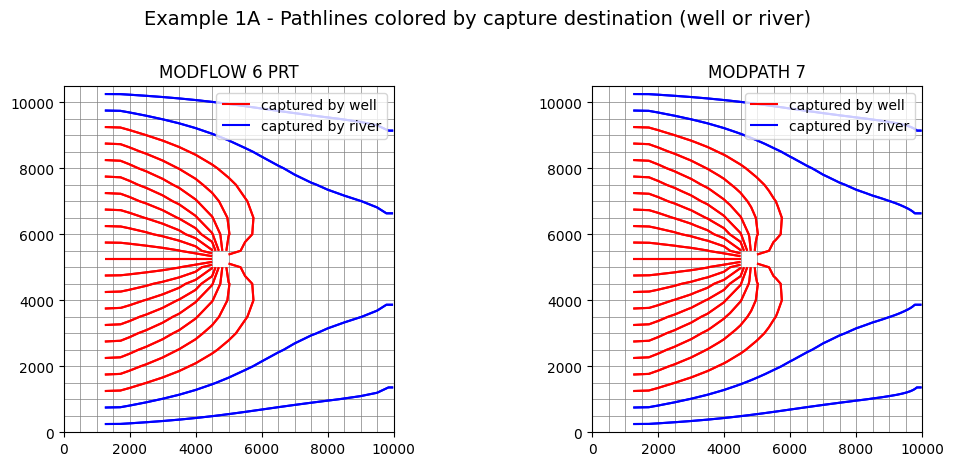

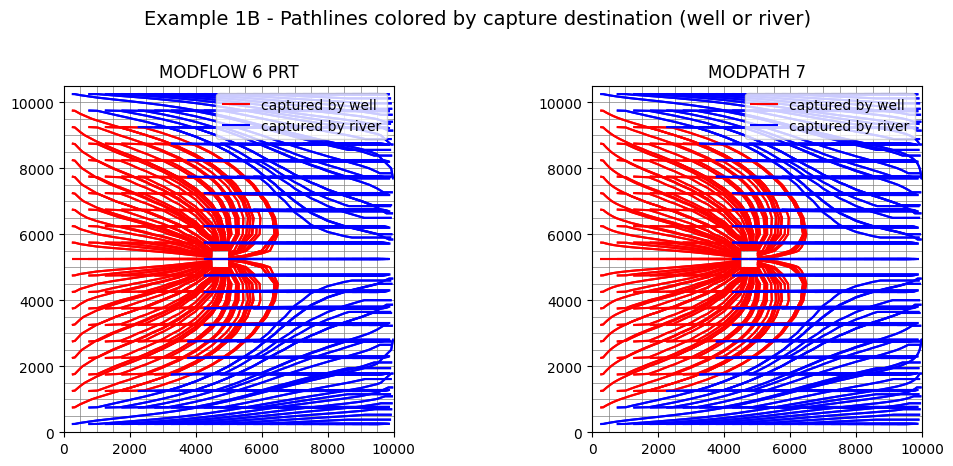

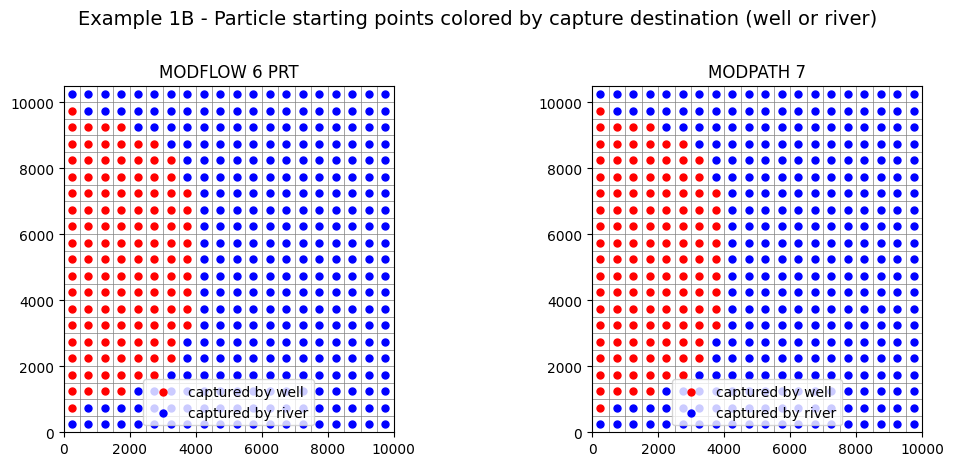

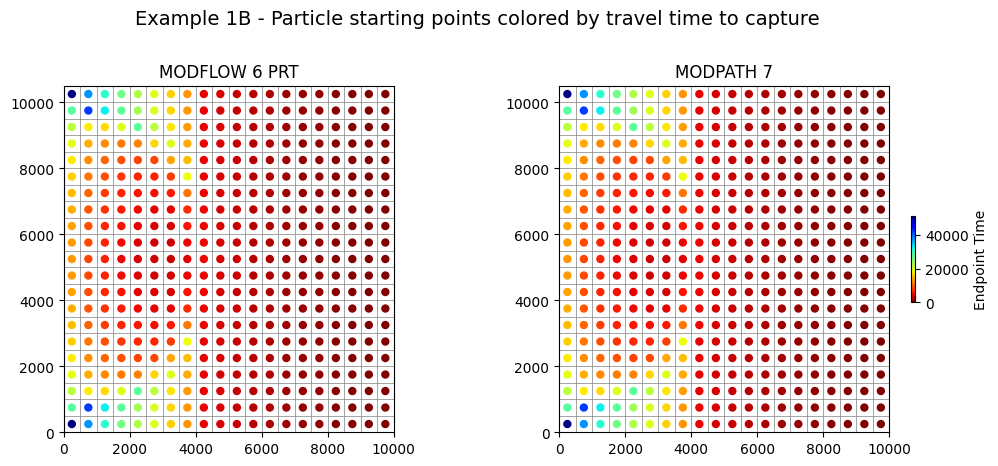

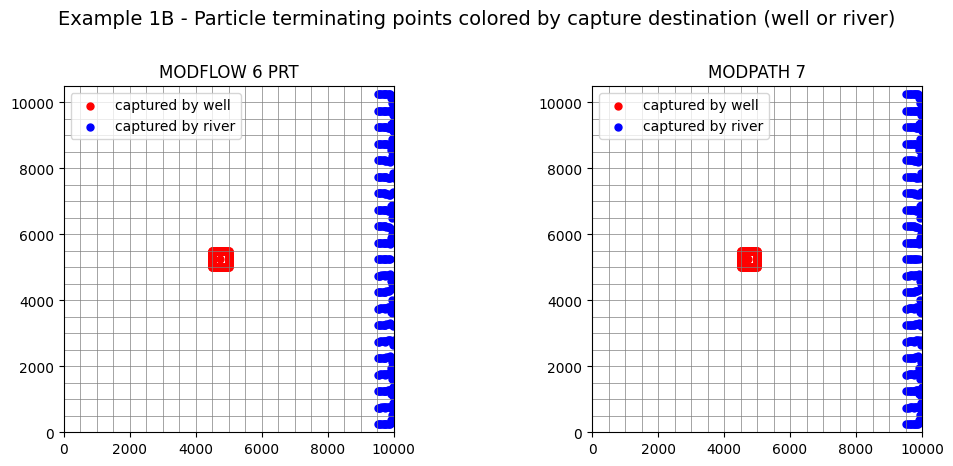

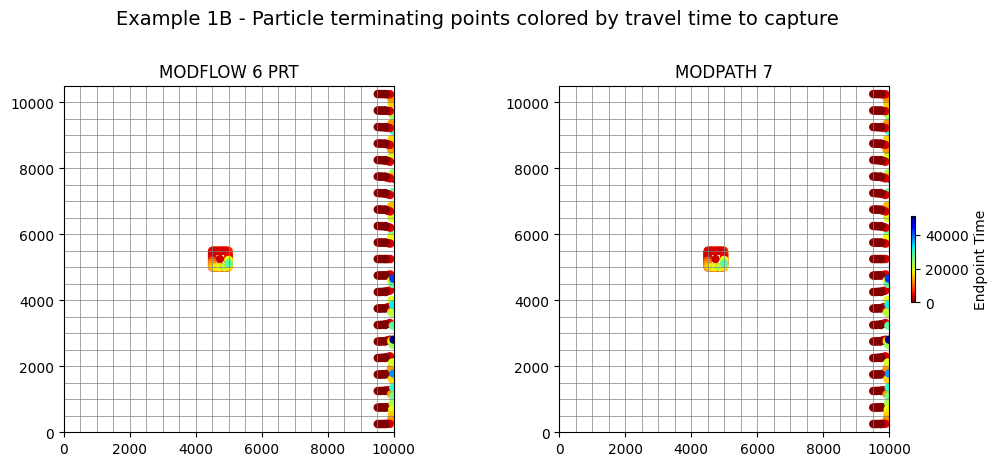

In [23]:
scenario(0, silent=False)